In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.numpy.linalg import slogdet
from jax.scipy.stats import multivariate_normal as mvtn
import matplotlib.pyplot as plt
import numpy as np
from t import t_logpdf
from jax_tqdm import scan_tqdm

/home/jannis/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def rbf_kernel(X1: jnp.ndarray,
                X2: jnp.ndarray,
                lengthscale: float) -> jnp.ndarray:
    sqdist = jnp.sum((X1[:, None, :] - X2[None, :, :]) ** 2, axis=-1)
    return jnp.exp(-0.5 * sqdist / (lengthscale ** 2))

In [4]:
# GP model

def log_pdf(y, X, lengthscale, amplitude, beta):
    return mvtn.logpdf(y, X @ beta, amplitude**2 * rbf_kernel(X, X, lengthscale))

def sample(key, X, lengthscale, amplitude, beta):
    return jax.random.multivariate_normal(key, X @ beta, amplitude**2 * rbf_kernel(X, X, lengthscale))

In [5]:
# we are working with a fixed lengthscale
lengthscale = 1.0

In [6]:
from jax.numpy.linalg import inv

# dof=n-p for right-invariant prior and dof=n for Jeffreys prior
def log_pred(yp, Xp, yo, Xo, dof):
    n_obs = len(yo)
    Xo = jnp.vstack((Xo, Xp))
    K = rbf_kernel(Xo, Xo, lengthscale)
    K_inv = inv(K)
    A = K_inv - K_inv @ Xo @ inv(Xo.T @ K_inv @ Xo) @ Xo.T @ K_inv
    Aoo, Aop, Apo, App = A[:n_obs, :n_obs], A[:n_obs, n_obs:], A[n_obs:, :n_obs], A[n_obs:, n_obs:]
    App_inv = inv(App)
    Sigma = (yo.T @ (Aoo - Aop @ App_inv @ Apo) @ yo / dof) * App_inv
    mu = - App_inv @ Apo @ yo
    return t_logpdf(yp, mu, Sigma, dof)

# dof=n-p for unbiased and dof=n for MLE
def log_pred_plug_in(yp, Xp, yo, Xo, dof):
    K = rbf_kernel(Xo, Xo, lengthscale)
    K_inv = inv(K)
    beta_hat = inv(Xo.T @ K_inv @ Xo) @ Xo.T @ K_inv @ yo
    amp_hat = jnp.sqrt((yo - Xo @ beta_hat).T @ K_inv @ (yo - Xo @ beta_hat) / dof)
    return log_pdf(yp, Xp, lengthscale, amp_hat, beta_hat)

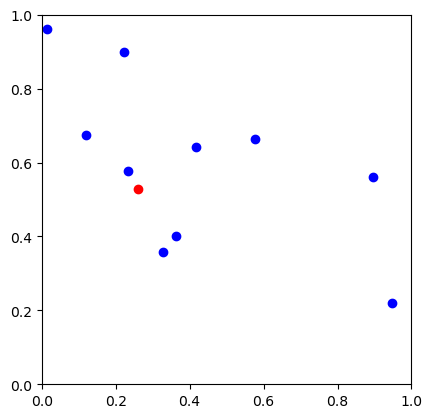

In [ ]:
# generate and visualize data
n, p = 10, 3
key_Xot, key_Xpt, key_mc = jax.random.split(jax.random.PRNGKey(0), 3)
Xot = jax.random.uniform(key_Xot, (10, p))[:n, :]
Xot = Xot.at[:, -1].set(1)  # add intercept
plt.scatter(Xot[:, 0], Xot[:, 1], label='observed', color='blue')
Xpt = jax.random.uniform(key_Xpt, (1, p))
Xpt = Xpt.at[:, -1].set(1)  # add intercept
plt.scatter(Xpt[:, 0], Xpt[:, 1], label='predictive', color='red')
# label scattered points with their index
for i in range(n):
    plt.annotate(str(i), (Xot[i, 0], Xot[i, 1]), fontsize=8, ha='right', va='bottom')
plt.xlim(0, 1)
plt.ylim(0, 1)
# square plot
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

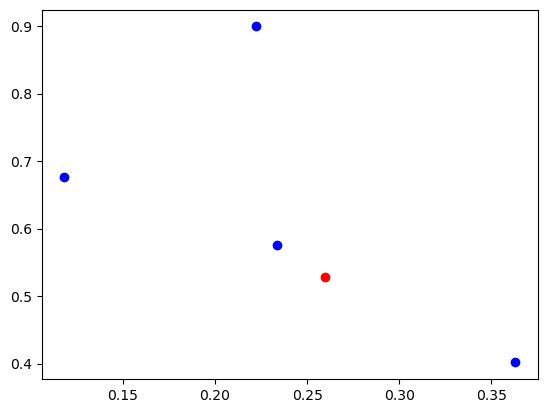

Running for 65,536 iterations:   0%|          | 0/65536 [00:00<?, ?it/s]

In [ ]:
# numerically evaluate predictive procedures against knowing true parameters

# parameters (should not affect the results)
# a, b = jnp.array(2, float), jax.random.uniform(jax.random.PRNGKey(42), (p,))
# a, b = jnp.array(20, float), jnp.array([-7, 5, 2], float)
a, b = jnp.array(1, float), jnp.array([7, 8, 3], float)

@jax.jit
def mc_estimate_risk(key, Xo, Xp, amplitude, beta):
    X = jnp.vstack((Xo, Xp))
    samples = sample(key, X, lengthscale, amplitude, beta)
    yo, yp = samples[:n], samples[n:]
    # true conditional likelihood
    true_pdf = log_pdf(samples, X, lengthscale, amplitude, beta) - log_pdf(yo, Xo, lengthscale, amplitude, beta)
    return jnp.array([
        # true_pdf,
        # true_pdf - log_pred(yp, Xp, yo, Xo, dof=n-p),
        # true_pdf - log_pred(yp, Xp, yo, Xo, dof=n),
        true_pdf - log_pred_plug_in(yp, Xp, yo, Xo, dof=n-p),
        true_pdf - log_pred_plug_in(yp, Xp, yo, Xo, dof=n)])

samples = 2 ** 16
iters = 2 ** 12

@scan_tqdm(iters)
def step(key, iter):
    key_now, key = jax.random.split(key, 2)
    keys = jax.random.split(key_now, samples)
    results = jax.vmap(mc_estimate_risk, (0, None, None, None, None))(keys, Xot, Xpt, a, b)
    mc_mean = jnp.nanmean(results, axis=0) 
    nans = jnp.sum(jnp.isnan(results), axis=0)
    return key, (iter, mc_mean, nans)
_, (_, mc_means, nans) = jax.lax.scan(step, key_mc, jnp.arange(iters))
print(jnp.mean(mc_means, axis=0), jnp.sqrt(jnp.nanvar(mc_means, axis=0, ddof=1) / iters), jnp.sum(nans, axis=0))

n=4 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:25<00:00, 160.82it/s]
[5.93776229e-01 1.81480577e+00 6.29701052e+03 2.51732644e+04] [6.00569421e-05 2.14062684e-04 3.72533356e+03 1.49013342e+04] [13766 13766     0     0]

n=5 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:30<00:00, 135.94it/s]
[0.46055812 0.85200079 5.68813504 5.51793252] [5.35540687e-05 1.16985917e-04 5.79757707e-05 6.15127522e-05] [0 0 0 0]

n=6 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:31<00:00, 128.92it/s]
[0.32967466 0.52207625 5.8482477  5.69610436] [4.77283311e-05 8.71710751e-05 5.19731104e-05 5.50532659e-05] [0 0 0 0]

n=7 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:32<00:00, 127.10it/s]
[0.45854481 0.57301563 6.39545909 6.30407988] [5.14318555e-05 7.88302776e-05 5.28852512e-05 5.74069630e-05] [0 0 0 0]

with true_pdf as first entry
n=6 [1.92361692 0.32967463 0.52207619 5.8482477  5.69610436] [4.24144205e-05 4.77283263e-05 8.71710611e-05 5.19731104e-05
 5.50532659e-05] [0 0 0 0 0]

n=7 [2.3647022  0.45854482 0.57301564 6.39545909 6.30407988] [4.34254816e-05 5.14318566e-05 7.88302801e-05 5.28852512e-05
 5.74069630e-05] [0 0 0 0 0]

n=8 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:34<00:00, 117.94it/s]
[5.98197705 0.24833167 0.32425693 7.04695409 6.96350834] [4.33259408e-05 4.06765289e-05 6.08527188e-05 5.11691341e-05
 5.51284920e-05] [0 0 0 0 0]

n=9 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:35<00:00, 115.12it/s]
[6.01901074 0.21764962 0.27170005 7.10289887 7.02659744] [4.38401392e-05 3.90504204e-05 5.55597142e-05 5.12387868e-05
 5.48180990e-05] [0 0 0 0 0]

n=10 Running for 4,096 iterations: 100%|██████████| 4096/4096 [00:36<00:00, 111.71it/s]
[6.3344146  0.13203049 0.17249193 7.45269697 7.39185891] [4.31069360e-05 3.10375458e-05 4.42682082e-05 4.97981696e-05
 5.33722220e-05] [0 0 0 0 0]0.1320

so the likelihood assigned by the predictive procedures improved, it's just that the likelihood we can assign knowing the true parameters improves even more

for different params:
n=6 [4.9193492  0.32967502 0.52207716 5.8482477  5.69610436] [4.24144205e-05 4.77284147e-05 8.71713414e-05 5.19731104e-05
 5.50532659e-05] [0 0 0 0 0]

n=7 [5.36043447 0.45854466 0.57301525 6.39545909 6.30407988] [4.34254816e-05 5.14318193e-05 7.88301974e-05 5.28852512e-05
 5.74069630e-05] [0 0 0 0 0]
So while the true_pdf is not invariant, the difference between different numbers of observations seems to be. The easiest way to show this would be that leaving one sample out when using the true parameters is an invariant predictive procedure. However, as we can see in the independent case in particular, the output clearly does not shift with the observations.